<a href="https://colab.research.google.com/github/arjoca/RHDocentes/blob/main/RHDocentes_Corrige.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RHDocentes - fevereiro 2022

**Notebook 3** - Correção das Desigualdades


Estudo organizado em 3 notebooks:
*   [O primeiro](https://github.com/arjoca/RHDocentes/blob/main/RHDocentes_Fotografia.ipynb) - Fotografia do ISEL
*   [O anterior](https://github.com/arjoca/RHDocentes/blob/main/RHDocentes_Futuro.ipynb) - O Futuro e a Dinâmica de Aposentações
*   **Este notebook** - Correção das Desigualdades

![perguntas](https://raw.githubusercontent.com/arjoca/RHDocentes/main/images/perguntas.svg)


# Metodologia proposta

![metodologia](https://raw.githubusercontent.com/arjoca/RHDocentes/main/images/algoritmo.svg)


# Fontes de informação

*   Ficheiro "Afetacao_Financeira_ADs_Cursos_2021_v01.xlsx"
*   Ficheiro "RAIDES_0.xlsx"

Informação que depois de filtrada e anonimizada deu origem aos dados guardados no ficheiro [clean_data.xlsx](https://github.com/arjoca/RHDocentes/blob/main/data/clean_data.xlsx), usados neste estudo.

# Preparação

## Importação de módulos e leitura de dados

In [1]:
# Instalação de módulos
!pip install kora -q
!pip install -U kaleido

     |████████████████████████████████| 57 kB 2.5 MB/s 
     |████████████████████████████████| 56 kB 3.0 MB/s 
     |████████████████████████████████| 79.9 MB 113 kB/s 


In [2]:
# Importação de módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from ipywidgets import widgets, interact, fixed
from IPython.display import Image

In [3]:
# Leitura de dados
base_url = 'https://raw.githubusercontent.com/arjoca/RHDocentes/main/data/'
docentes = pd.read_csv(base_url + 'docentes.csv', encoding= 'unicode_escape', 
                       parse_dates=['Data Nascimento'], infer_datetime_format=True)
alunos_per_curso = pd.read_csv(base_url + 'alunos.csv', encoding= 'unicode_escape', index_col=0)
horas = pd.read_csv(base_url + 'horas.csv', encoding= 'unicode_escape', index_col=0)

## Inicializações

In [4]:
# Designações dos cursos e departamentos
LISTA_DEPTS = sorted(docentes['Departamento'].unique())
LISTA_CURSOS = sorted(alunos_per_curso.index.unique())

In [5]:
# Designações das categorias de docentes
cat_prof_coord = ['Prof. Coordenador', 'Prof. Coordenador c/ Agreg. ', 'Professor Coordenador Principal']
cat_convidado = ['Assistente Convidado', 'Professor Adjunto Convidado']
cat_adjunto = ['Professor Adjunto']
cat_assistente = ['Assistente do 2. Trienio', 'Assistente', 'Equiparado Assistente 2. Trienio']
cat_monitor = ['Monitor']
cat_quadro = cat_prof_coord + cat_adjunto
cat_todas = cat_quadro + cat_convidado + cat_assistente + cat_monitor

In [6]:
# Dicionários com categorias de docentes e suas designações
catgs = {'Coordenadores':cat_prof_coord, 
         'Adjuntos': cat_adjunto,
         'Quadro': cat_quadro,
         'Convidados': cat_convidado,
         'ETIs': cat_todas,
         'ETIs++': 'ETIs++'}
inv_catgs = {tuple(v): k for k, v in catgs.items()}

In [7]:
# Horas de contacto usadas para determinar relações entre cursos e departamentos
horas_per_curso = horas.sum(axis=1)
pesos_dept_per_curso = horas.T / horas_per_curso

# Alunos por departamento
alunos_per_dept = pd.DataFrame(np.dot(pesos_dept_per_curso, alunos_per_curso),
                              index=pesos_dept_per_curso.index, columns=['Alunos'])
alunos_per_dept = alunos_per_dept['Alunos']
alunos_per_dept.name = ''
alunos_per_dept = alunos_per_dept.sort_index()

In [8]:
# Números globais
alunos_per_eti_isel = alunos_per_curso.sum().sum() / docentes['ETI'].sum()
eti_per_dept = docentes.groupby(['Departamento'])['ETI'].sum()

In [9]:
# ETIs VIANA (Valor Ideal Atendendo ao Número de Alunos)
viana = alunos_per_dept / alunos_per_eti_isel
fana = viana - eti_per_dept

## Funções usadas nos anteriores notebooks 

In [10]:
# Filtragem de docentes atendendo à sua idade de aposentação 
def aposentados_e_ativos(df, ano, idade_reforma):
  idade = (datetime(ano, 1, 1) - df['Data Nascimento'])/timedelta(days=365.25)
  aposentados = df[idade > idade_reforma]
  ativos = df.drop(index=aposentados.index)
  return aposentados, ativos

In [11]:
# Filtragem de docentes atendendo à sua categoria
def docentes_per_categoria(df, categoria):
  s = df.groupby(['Departamento', 'Categoria'])['ETI'].sum()
  s = s.loc[(slice(None), categoria)].droplevel(level=1)
  s = s.groupby(s.index).sum()
  s = pd.Series(s, index=LISTA_DEPTS)
  return s.fillna(0)

# Medição das desigualdades (coeficiente de Gini)

$$G=\frac{\sum_{i=1}^n (2i-n-1)x_i}{n\sum_{i=1}^n x_i}$$

onde $\{x_i\}$ é o conjunto dos $n$ valores da distribuição, ordenados por ordem crescente ($i$ é o ranking de $x_i$)

$$0 \le G \le 1$$
$(G=0) \Rightarrow$ **não há desigualdades** (valores da distribuição todos iguais)

$(G \approx 1) \Rightarrow$ ***winner-takes-all*** (todos os valores a zero, exceto um)

Fontes:
*   [Statistical/Help - Gini Coefficient of Inequality](http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm)
*   [GitHub - Olivia Guest](https://github.com/oliviaguest/gini)

**Alternativa:** Usar definição de Entropia da Teoria de Informação, $E=-\sum_{i=1}^n x_i log(x_i)$

Neste caso, quanto maior é o valor da entropia, menores serão as desigualdades.


In [12]:
# Função para calcular o coeficiente de Gini
def gini(array):
    array = array.flatten()
    if np.amin(array) < 0:
        array -= np.amin(array)
    array += 0.0000001
    array = np.sort(array)
    index = np.arange(1,array.shape[0]+1)
    n = array.shape[0]
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

# Três métodos para fazer a distribuição

In [13]:
# Função auxiliar para determinar quanto falta para o target
def how_many_to_target(target, numerator, denominator):
  s = denominator * target - numerator
  s.clip(lower=0, inplace=True)
  return s

In [14]:
# METHOD 1 - Linear mapping
def linear_map(target, cake, numerator, denominator):
  s = how_many_to_target(target, numerator, denominator)
  return s / s.sum() * cake

In [15]:
# METHOD 2 - D'Hondt
def method_hondt(target, cake, numerator, denominator):
  s = how_many_to_target(target, numerator, denominator)
  list_of_series = [s/i for i in range(1, cake+1)]
  df = pd.concat(list_of_series, axis=1)
  vals = np.sort(np.ravel(df.to_numpy(copy=True)))[-1::-1]
  df = df >= vals[cake-1]
  return df.sum(axis=1)

# METHOD 2a - D'Hondt
def method_hondt_ordering(target, cake, numerator, denominator):
  s = how_many_to_target(target, numerator, denominator)
  list_of_series = [s/i for i in range(1, cake+1)]
  df = pd.concat(list_of_series, axis=1)
  vals = np.sort(np.ravel(df.to_numpy(copy=True)))[-1::-1]
  df_ordering = pd.DataFrame(index=LISTA_DEPTS)
  for i,v in enumerate(vals[:cake]):
    ix = df[df==v].stack().index.get_level_values(0)
    df_ordering.loc[ix, i+1] = 1
  return df_ordering

In [16]:
# METHOD 3 - One step iteration
def step_by_step(cake, numerator, denominator):
  df = pd.DataFrame(index=LISTA_DEPTS)
  num = numerator.copy()
  den = denominator.copy()
  for i in range(cake):
    ratio = num / den
    ix = ratio.idxmin()
    num[ix] += 1
    df.loc[ix,i+1] = 1
  return df

# Exercício de comparação

## Funções de auxílio

In [17]:
# Mostrar resultados na forma de gráficos
def show_results(num, den, s, df, bolo, target, ano, reforma, denominador, metodo):
  fig, ax = plt.subplots(2, 2, figsize=(17,8))
  fig.subplots_adjust(hspace=0.5)
  title1 = f'Distribuição de {bolo} vagas - método {metodo}, '
  title2 = ''
  if metodo != 'step_by_step':
    title2 += f'target= {target}, '
  title3 = f'denominador={inv_catgs[tuple(denominador)]}, ano={ano}, idade_reforma={reforma}'
  fig.suptitle(title1 + title2 + title3)

  s.name=''
  s.plot(kind='bar', ax=ax[0,0], table=np.round(s,1).to_frame().T, cmap='PuOr')
  ax[0,0].set_title('Distribuição do bolo pelos departamentos')
  ax[0,0].xaxis.set_visible(False)
  if df is not None:
    sns.heatmap(df, cbar=False, linewidths=2, linecolor='grey', ax=ax[0,1], cmap='PuOr')
    ax[0,1].set_title('Ordenação da distribuição')
 
  # Valores antes da distribuição
  s1 = num/den
  s1.name = ''
  s1.plot(kind='bar', ax=ax[1,0], table=np.round(s1,2).to_frame().T)
  ax[1,0].xaxis.set_visible(False)
  ax[1,0].axhline(y=s1.mean(), linewidth=2, color='#d62728')
  ax[1,0].set_title(f'Rácios antes da distribuição - Coef. Gini = {np.round(gini(s1.values),3)}')
  # Valores depois da distribuição
  s2 = (num+s)/den
  s2.name = ''
  s2.plot(kind='bar', ax=ax[1,1], table=np.round(s2,2).to_frame().T)
  ax[1,1].xaxis.set_visible(False)
  ax[1,1].axhline(y=s2.mean(), linewidth=2, color='#d62728')
  ax[1,1].set_title(f'Rácios depois da distribuição - Coef. Gini = {np.round(gini(s2.values),3)}')

  fig.savefig('temp_image.png')

In [18]:
# Função chamada de forma interativa usando widgets
def main_func(bolo=8, target=0.25, ano=2022, reforma=68, denominador='ETIs++', 
        metodo='hondt'):
  _, ativos = aposentados_e_ativos(docentes, ano, reforma)
  num = docentes_per_categoria(ativos, cat_prof_coord)
  
  if denominador != 'ETIs++':
    den = docentes_per_categoria(ativos, denominador)
  else:
    den = docentes_per_categoria(ativos, cat_todas) + fana

  if metodo == 'linear':
    df = None
    s = linear_map(target, bolo, num, den)
  elif metodo == 'hondt':
    df = method_hondt_ordering(target, bolo, num, den)
    s = df.sum(axis=1)
  elif metodo == 'step_by_step':
    df = step_by_step(bolo, num, den)
    s = df.sum(axis=1)
  else: print('Erro: método inexistente')  
  
  show_results(num, den, s, df, bolo, target, ano, reforma, denominador, metodo)

## Simulação interativa

In [19]:
# Simulação interativa
interact(main_func, bolo=(4,80,1), target=(0.15,0.75,0.05), ano=(2022,2030,1), 
         reforma=(67,70,1), denominador={'ETIs':cat_todas, 
                                         'Quadro': cat_quadro, 
                                         'ETIs++': 'ETIs++'}, 
         metodo=['linear','hondt','step_by_step'])

interactive(children=(IntSlider(value=8, description='bolo', max=80, min=4), FloatSlider(value=0.25, descripti…

<function __main__.main_func>

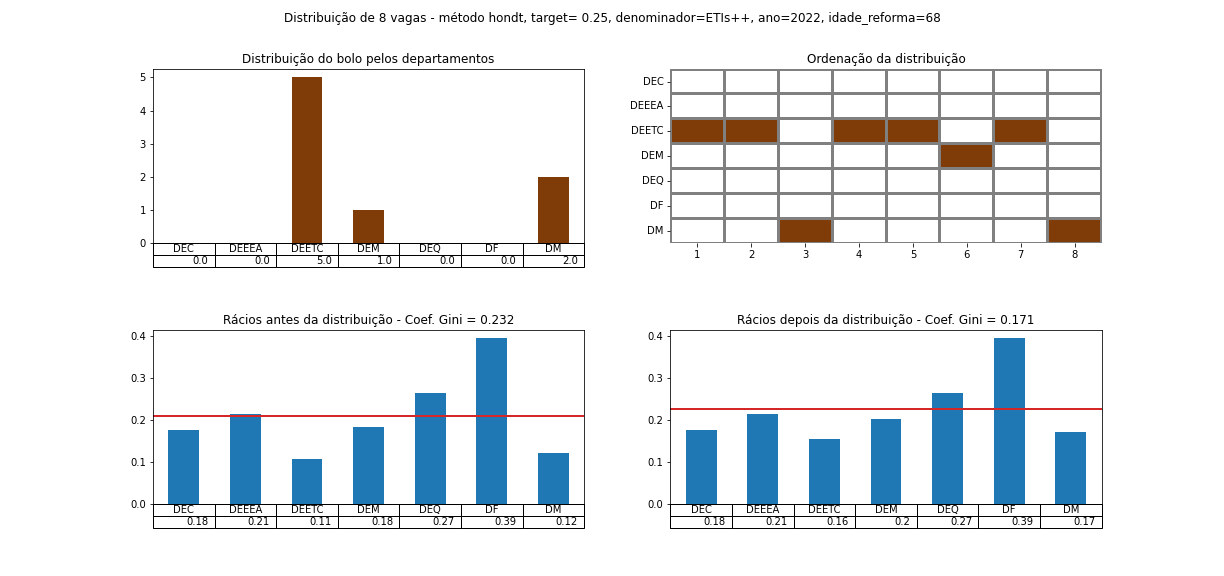

In [20]:
Image('temp_image.png')